In [4]:
# !conda install -y gdown
# !gdown --id 16a9OiPKOE8anJd-yX7DUdkMvY_9EhKff

# ! unzip /kaggle/working/dfa.zip

# !pip install geopy
# !pip install catboost
# !pip install pycountry
# !pip install ipaddress
# !pip install optuna
# !pip install category_encoders

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lg
import optuna
from category_encoders import *
import catboost as ct
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import pickle
SEED = 123
%matplotlib inline
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

In [8]:

dataset =pd.read_csv(r"/kaggle/working/content/gdrive/MyDrive/Tech documents/Deep learning/Datafest 23/FraudDetectionDataset.csv",nrows=800000)

In [10]:
loc_data  = pd.read_csv("/kaggle/working/content/gdrive/MyDrive/Tech documents/Deep learning/Datafest 23/location.csv",nrows=800000)

loc_data.head()

,User's Device Location,Latitude,Longitude
0,United Kingdom,54.702354,-3.276575
1,Mexico,23.658512,-102.007710
2,Qatar,25.333698,51.229529
3,Spain,39.326068,-4.837979
4,Israel,30.812425,34.859476


In [11]:
dataset  = pd.merge(dataset,loc_data,on  = "User's Device Location",how  = "left")

In [12]:
dataset.head(2)

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,...,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag,Latitude,Longitude
0,51595306,9822,163.08,2023-01-02 07:47:54,4044,ACH Transfer,KOR,Charity,GPS Device,42.23.223.120,...,United Kingdom,NOK,Consultation Fee,343,cox.co.uk,3,Bluetooth Authentication,0,54.702354,-3.276575
1,85052974,4698,430.74,2021-09-12 15:15:41,4576,2Checkout,VNM,Cashback,Medical Device,39.52.212.120,...,Mexico,EGP,Cashback Reward,688,gmail.com,13,NFC Tag,1,23.658512,-102.007710


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Transaction ID                     800000 non-null  int64  
 1   User ID                            800000 non-null  int64  
 2   Transaction Amount                 800000 non-null  float64
 3   Transaction Date and Time          800000 non-null  object 
 4   Merchant ID                        800000 non-null  int64  
 5   Payment Method                     800000 non-null  object 
 6   Country Code                       800000 non-null  object 
 7   Transaction Type                   800000 non-null  object 
 8   Device Type                        800000 non-null  object 
 9   IP Address                         800000 non-null  object 
 10  Browser Type                       800000 non-null  object 
 11  Operating System                   8000

In [15]:
dataset = dataset.drop(labels=["Transaction ID",'User ID','Merchant ID','IP Address'],axis=1)

## Exploratory Data Analysis

Fraudulent Flag
0    0.500066
1    0.499934
Name: proportion, dtype: float64

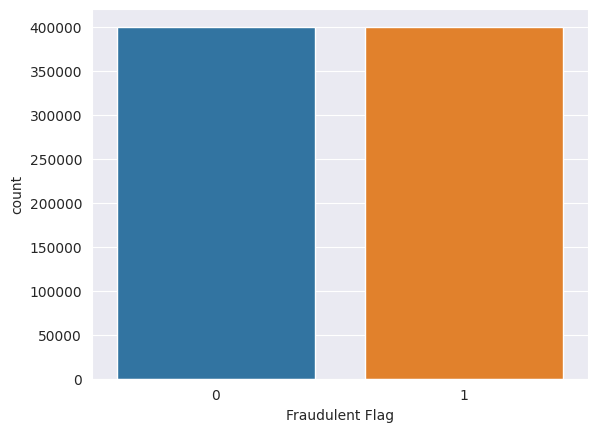

In [61]:
sns.countplot(x='Fraudulent Flag',data=dataset)
# plt.title('fraudlent count')

dataset['Fraudulent Flag'].value_counts(normalize=True)

In [18]:
#a function is created to avoid repeating code for plots
def chart(x_label,y_label,title):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

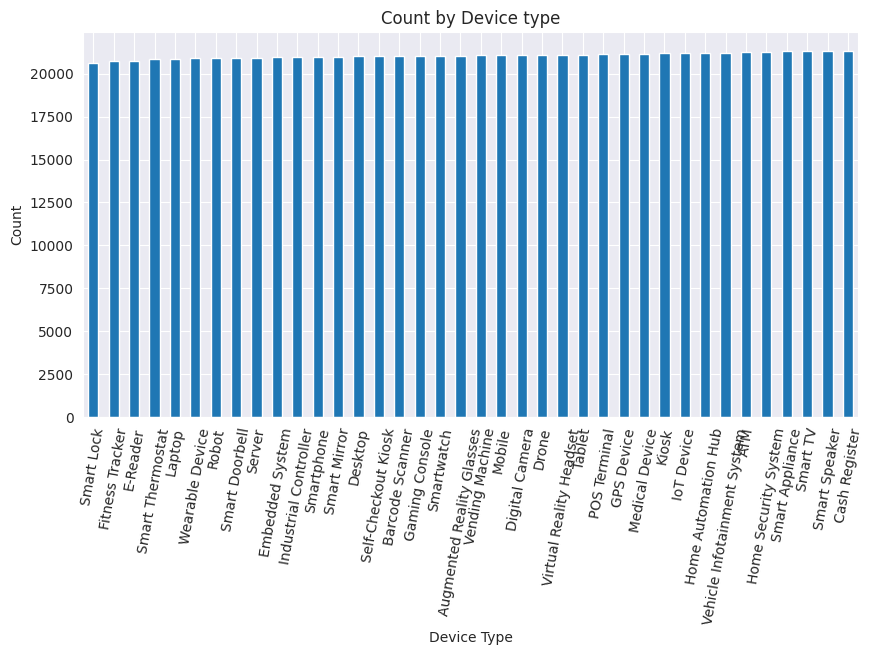

In [62]:
plt.figure(figsize=(10,5))
dataset['Device Type'].value_counts(ascending= True).plot(kind ='bar')
plt.title('Count by Device type')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=80);



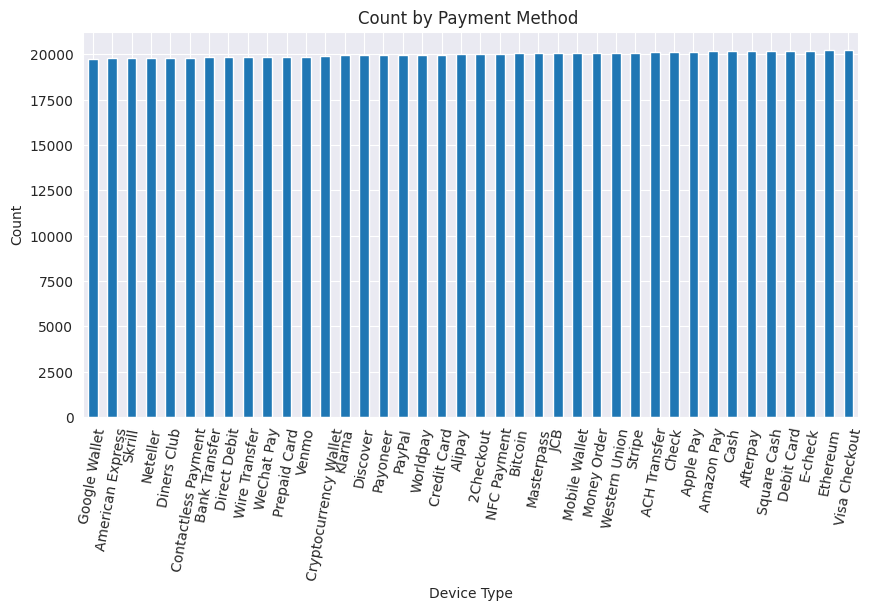

In [63]:
plt.figure(figsize=(10,5))
dataset['Payment Method'].value_counts(ascending= True).plot(kind ='bar')
plt.title('Count by Payment Method ')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=80);

## **Feature Engineering**

In [22]:
data = dataset

data['Transaction Date and Time'] = pd.to_datetime(data['Transaction Date and Time'],errors='coerce')

####  **Extract date and time features**

In [23]:

def extract_date_info(df,cols):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.year
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
        df[feat +'_weekday'] = df[feat].dt.weekday
        df[feat +'_hour'] = df[feat].dt.hour
        df[feat +'_minute'] = df[feat].dt.minute
        df[feat +'_minute'] = df[feat].dt.second

    data.drop(columns=['Transaction Date and Time'],axis=1,inplace=True)


extract_date_info(data,['Transaction Date and Time'])

In [24]:
data_string = data.select_dtypes(include='object')
data_int = data.select_dtypes(include=['int','float'])

data_string.head(2)

,Payment Method,Country Code,Transaction Type,Device Type,Browser Type,Operating System,Merchant Category,User Occupation,User Gender,User Account Status,Transaction Status,Transaction Time of Day,User's Device Location,Transaction Currency,Transaction Purpose,User's Email Domain,Transaction Authentication Method
0,ACH Transfer,KOR,Charity,GPS Device,Links,Tizen,Industrial & Scientific,Doctor,Prefer Not to Say,Pro,In Transit,Daytime,United Kingdom,NOK,Consultation Fee,cox.co.uk,Bluetooth Authentication
1,2Checkout,VNM,Cashback,Medical Device,Beaker,Windows Server,Beauty & Cosmetics,Chemist,Genderqueer,Pending Approval,Resolved,Daytime,Mexico,EGP,Cashback Reward,gmail.com,NFC Tag


In [25]:
data_int.head(5)

,Transaction Amount,User Age,User Income,Location Distance,Time Taken for Transaction,User's Transaction History,Merchant's Reputation Score,User's Credit Score,Merchant's Business Age,Fraudulent Flag,Latitude,Longitude,Transaction Date and Time_year,Transaction Date and Time_day,Transaction Date and Time_month,Transaction Date and Time_quarter,Transaction Date and Time_weekday,Transaction Date and Time_hour,Transaction Date and Time_minute
0,163.08,68,66826.21,9.34,24.22,26,2.71,343,3,0,54.702354,-3.276575,2023,2,1,1,0,7,54
1,430.74,22,89356.71,65.28,55.11,60,3.95,688,13,1,23.658512,-102.007710,2021,12,9,3,6,15,41
2,415.74,71,58438.63,44.05,53.84,81,3.81,371,7,1,25.333698,51.229529,2023,12,1,1,3,17,58
3,565.89,78,3426.92,21.70,21.62,18,2.67,687,15,1,39.326068,-4.837979,2021,27,2,1,5,11,0
4,955.49,31,53080.12,56.63,53.71,98,3.19,605,17,1,30.812425,34.859476,2022,24,9,3,5,4,38


#### **Extract the domain and extension name from email**

In [26]:

data['domain'] = data["User's Email Domain"].apply(lambda x : x.split(".", 1)[0])
data['extension'] = data["User's Email Domain"].apply(lambda x : x.split(".", 1)[1])

#### **Divide the users and merchant age into bins so that the ml model can understand it better**

In [28]:
#divide the 
data['User Age_count'] = pd.qcut(data['User Age'], q = [0, .2, .4, .6, .8, 1], labels=False)
data['merchant_count'] = pd.qcut(data["Merchant's Business Age"], q = [0, .2, .4, .6, .8, 1], labels=False)

In [29]:
data = data.drop(labels=['User Age',"Merchant's Business Age","User's Email Domain"],axis =1)

### **Split the data into train and test set**

In [30]:
# train = data.iloc[:5000000,:]
# test = data.iloc[5000000:,:]

train = data.iloc[:700000,:]
test = data.iloc[700000:,:]

t_target = train['Fraudulent Flag']
t_data = train.drop(labels=['Fraudulent Flag'],axis =1)

### Drop the target variable

In [31]:
test_target = test['Fraudulent Flag']
test = test.drop(labels=['Fraudulent Flag'],axis =1)

### **Encode the categorical varibles using targer encoder**

In [42]:
target = ['Payment Method','Country Code','Device Type','Transaction Type','Browser Type','Operating System','Merchant Category','User Gender','User Account Status','Transaction Status','Transaction Time of Day',
"User's Device Location", 'Transaction Currency', 'Transaction Purpose','Transaction Authentication Method','domain','extension']

enc = TargetEncoder(cols=t_data[target])
ordi = OrdinalEncoder(cols=t_data[['User Occupation']]) 
scaler = StandardScaler() 
list_tras = [enc,ordi,scaler]    
    
def cat_transform(train_data,test_data, target,transforms):    
    for i in transforms:
        i.fit(train_data,target)
        train_data = i.transform(train_data) 
        test_data = i.transform(test_data)    
    return train_data,test_data
    
tr_data, te_test = cat_transform(t_data,test,t_target,list_tras)    
    
t_data = pd.DataFrame(tr_data,columns= t_data.columns)
test = pd.DataFrame(te_test,columns= t_data.columns)    
    
t_data

,Transaction Amount,Payment Method,Country Code,Transaction Type,Device Type,Browser Type,Operating System,Merchant Category,User Occupation,User Income,...,Transaction Date and Time_day,Transaction Date and Time_month,Transaction Date and Time_quarter,Transaction Date and Time_weekday,Transaction Date and Time_hour,Transaction Date and Time_minute,domain,extension,User Age_count,merchant_count
0,-1.168196,0.327958,1.330197,-1.049516,-0.768695,0.252903,-1.280853,-1.108530,-1.666886,0.570849,...,-1.558532,-1.481067,-1.222849,-1.503043,-0.648550,1.416806,1.317559,0.027625,0.728773,-1.413317
1,-0.240179,-0.567821,-0.705717,0.136925,-0.822087,0.639357,1.227446,-0.691900,-1.533451,1.358609,...,-0.419222,0.906099,0.612668,1.495287,0.506216,0.666104,0.016139,-0.120594,-1.392076,0.710027
2,-0.292187,-0.378021,2.386532,0.577079,-1.041779,1.546018,-0.430404,-0.018087,-1.400016,0.277585,...,-0.419222,-1.481067,-1.222849,-0.003878,0.794907,1.647792,-0.799000,-0.120594,1.435723,-0.705536
3,0.228406,0.334583,-0.944772,0.815061,0.572896,-0.490098,2.086538,-0.271907,-1.400016,-1.645852,...,1.289741,-1.182672,-1.222849,0.995566,-0.071167,-1.701498,-0.615031,0.027625,1.435723,0.710027
4,1.579206,1.829851,-0.312792,-0.749349,-0.872031,0.343418,-1.707091,0.132040,-1.266581,0.090229,...,0.947949,0.906099,0.612668,0.995566,-1.081587,0.492864,0.554096,0.027625,-0.685126,1.417809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,-0.847485,0.198899,1.083170,0.577079,-0.722063,0.190358,-1.280853,-0.510198,-1.400016,1.510107,...,-1.558532,1.801286,1.530427,-0.003878,1.516635,-0.777556,-1.947326,-0.120594,0.728773,-1.413317
699996,0.662354,-0.593972,-0.944772,0.694069,0.572896,0.942132,-0.265058,-1.108530,1.268687,1.331221,...,-1.216739,-1.481067,-1.222849,-0.503600,-1.514624,-0.084599,0.193986,0.027625,1.435723,-0.705536
699997,-0.922583,-0.973800,0.114711,1.599728,2.033523,-0.503989,0.774981,-1.108530,1.402122,-1.165734,...,-0.874946,1.204495,1.530427,0.995566,-1.370278,1.243567,0.016139,-0.120594,-1.392076,-0.705536
699998,-1.106342,-0.378021,1.083170,-2.252545,-1.525420,0.775650,-0.793823,-1.516312,0.868382,0.237749,...,-1.216739,-0.287484,-0.305091,0.495844,1.227944,-0.835302,0.554096,-0.120594,0.021824,0.002246


### **Split the data into train and test set**

In [39]:
train_x, test_x, train_y, test_y = train_test_split(t_data, t_target, test_size=0.2,random_state=SEED)

### **Train the model**

In [40]:
model = ct.CatBoostClassifier(eval_metric = 'Accuracy')

In [41]:
model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=10,verbose=True)
preds = model.predict(test_x)
acc = accuracy_score(test_y, preds)
print(acc)

Learning rate set to 0.151256
0:	learn: 0.5063946	test: 0.5038643	best: 0.5038643 (0)	total: 263ms	remaining: 4m 23s
1:	learn: 0.5094536	test: 0.5054071	best: 0.5054071 (1)	total: 420ms	remaining: 3m 29s
2:	learn: 0.5100143	test: 0.5055714	best: 0.5055714 (2)	total: 577ms	remaining: 3m 11s
3:	learn: 0.5107036	test: 0.5071500	best: 0.5071500 (3)	total: 732ms	remaining: 3m 2s
4:	learn: 0.5120732	test: 0.5064357	best: 0.5071500 (3)	total: 907ms	remaining: 3m
5:	learn: 0.5130446	test: 0.5058571	best: 0.5071500 (3)	total: 1.08s	remaining: 2m 59s
6:	learn: 0.5135607	test: 0.5057143	best: 0.5071500 (3)	total: 1.25s	remaining: 2m 56s
7:	learn: 0.5137875	test: 0.5051857	best: 0.5071500 (3)	total: 1.39s	remaining: 2m 52s
8:	learn: 0.5145679	test: 0.5055000	best: 0.5071500 (3)	total: 1.56s	remaining: 2m 52s
9:	learn: 0.5151286	test: 0.5057857	best: 0.5071500 (3)	total: 1.73s	remaining: 2m 50s
10:	learn: 0.5162036	test: 0.5068000	best: 0.5071500 (3)	total: 1.88s	remaining: 2m 49s
11:	learn: 0.5162

In [43]:
confusion_matrix(test_y, preds)

array([[35901, 34390],
       [34609, 35100]])